# Colour content-based image retrieval system architecture
---

---
**Name : Giulia Hossu**  
**Description : Color Space Based Image Retrieval System**  
**Discipline : SACCM, TUCN**
___

Un sistem de recuperare a imaginilor bazat pe conținutul culorilor este o tehnologie care permite utilizatorilor să găsească imagini similare  
într-o bază de date de imagini pe baza caracteristicilor lor de culoare.
Acest sistem are o arhitectură care constă în mai multe componente esențiale pentru a funcționa eficient

# Importarea bibliotecilor necesare

In [5]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

# Încărcarea datelor

 Definim o funcție care verifică dacă numele fișierului are o extensie de fișier validă.

In [6]:
def is_valid_image_file(filename):
    valid_extensions = (".jpg", ".jpeg", ".png", ".bmp", ".gif", ".tiff", ".tif")
    return filename.lower().endswith(valid_extensions)

Funcția principală care încarcă imagini dintr-un director dat și le validează.

In [7]:
def load_images_from_folder(folder):
    images = []  # O listă pentru a stoca imaginile încărcate
    new_width = 800  # Lățimea la care se va redimensiona fiecare imagine
    new_height = 600  # Înălțimea la care se va redimensiona fiecare imagine

    for filename in os.listdir(folder):
        if is_valid_image_file(filename):
            # Dacă numele fișierului are o extensie de fișier validă, continuăm.
            img = cv2.imread(os.path.join(folder, filename))  # Citim imaginea
            if img is not None and img.shape[0] > 0 and img.shape[1] > 0:
                # Dacă imaginea a fost încărcată corect și are dimensiuni nenule
                resized_image = cv2.resize(img, (new_width, new_height))  # Redimensionăm imaginea
                images.append(resized_image)  # Adăugăm imaginea redimensionată la listă
            elif img is None:
                print(f"Error: Could not load image {filename}")
                # Dacă imaginea nu a putut fi încărcată, afișăm un mesaj de eroare.
            else:
                print(f"Warning: Invalid image dimensions in {filename}")
                # Dacă imaginea nu are dimensiuni valide, afișăm un avertisment.
    return images  # Returnăm lista cu imaginile încărcate și redimensionate.

Apelăm funcția

In [8]:
images = load_images_from_folder('./data')

Afișăm numărul de poze găsite

In [10]:
print("Total Images : {}".format(len(images)))

Total Images : 30


Deoarece imaginile încărcate de OpenCV sunt în spațiul de culoare BGR, în timp ce matplotlib se așteaptă la imagini în format RGB, vom converti din BGR în RGB.

In [11]:
%%time
#măsoară timpul de execuție al codului care transformă imaginile din formatul BGR în formatul RGB folosind OpenCV
images_rgb = [cv2.cvtColor(image, cv2.COLOR_BGR2RGB) for image in images]

CPU times: user 13.3 ms, sys: 17.3 ms, total: 30.6 ms
Wall time: 40.7 ms


Afișăm toate pozele disponibile în baza de date

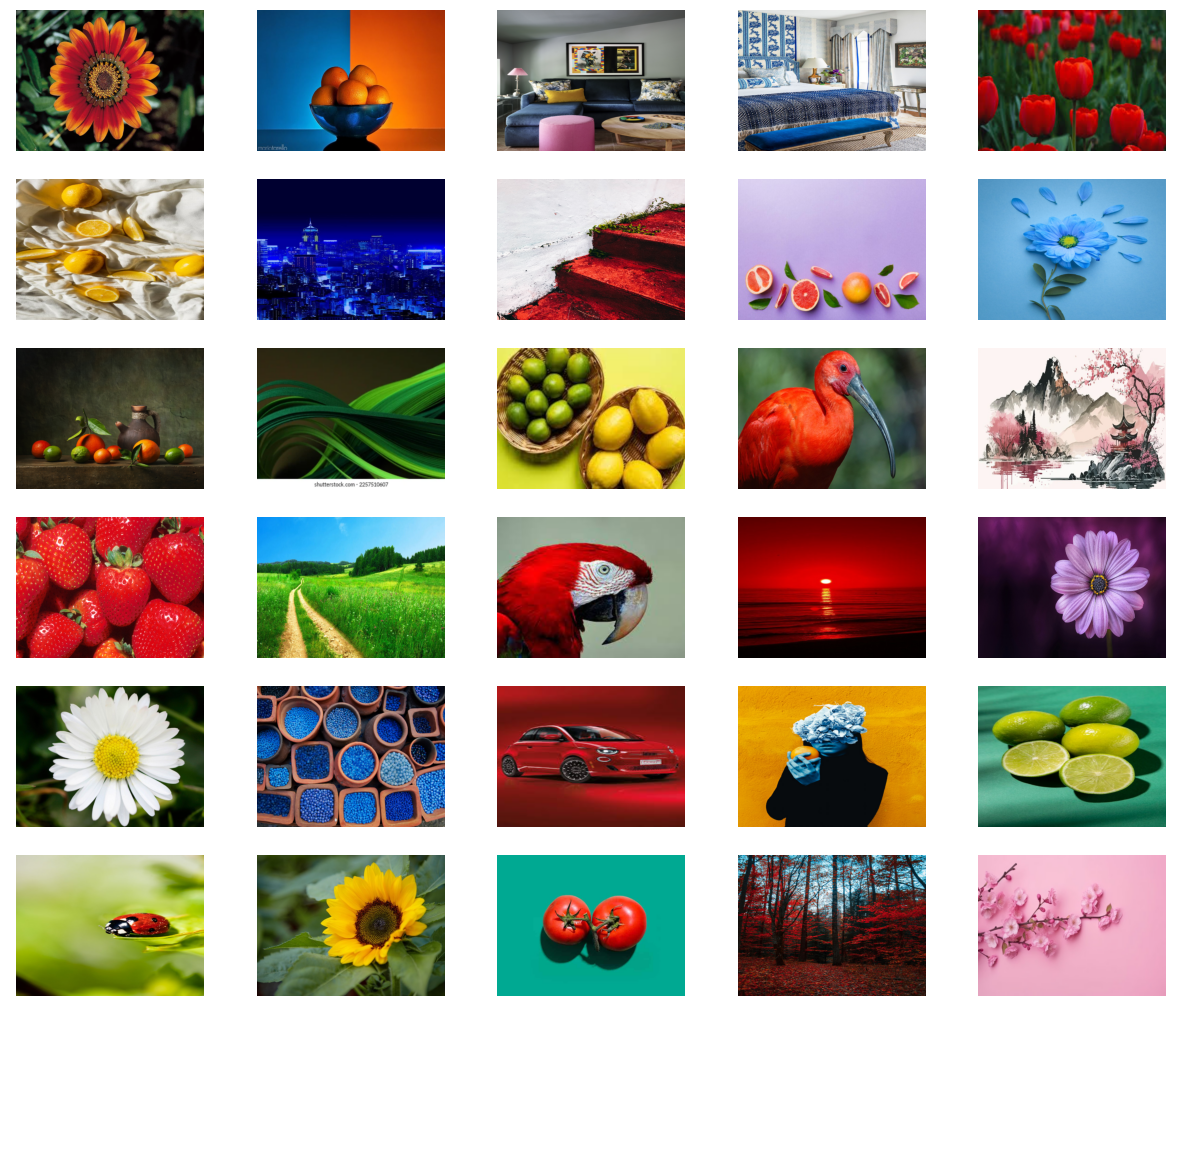

In [12]:
num_rows = len(images_rgb) // 5 + 1
fig, axes = plt.subplots(num_rows, 5, figsize=(15, 15))

for i, ax in enumerate(axes.flat):
    if i < len(images_rgb):
        ax.imshow(images_rgb[i])
        ax.axis('off')
    else:
        ax.axis('off')

plt.show()

Alegem o poză de test

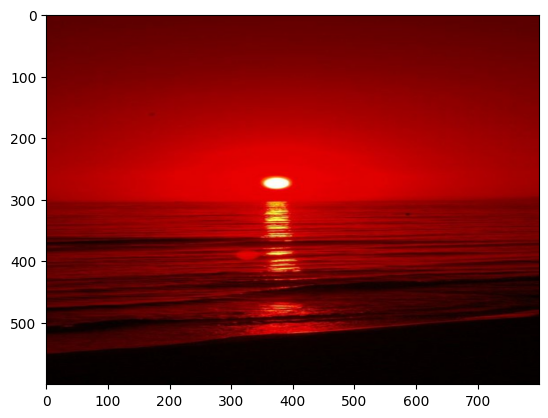

In [13]:
poza_test=18
plt.imshow(images_rgb[poza_test])

# Preprocesare
 Imaginea de intrare este prelucrată pentru a extrage caracteristicile de culoare relevante.

**Din RGB la HSV și înapoi la RGB**

Convertirea unei imagini din spațiul de culoare RGB (Red-Green-Blue) în spațiul de culoare HSV (Hue-Saturation-Value) și apoi înapoi în RGB poate fi utilă în diverse aplicații de prelucrare a imaginilor.

*Separarea culorilor:* Spațiul de culoare HSV permite o separare mai eficientă a componentelor de culoare, cum ar fi nuanța, saturația și valoare.


In [14]:
%%time
images_hsv = [cv2.cvtColor(image, cv2.COLOR_BGR2HSV) for image in images]

CPU times: user 86.1 ms, sys: 39.4 ms, total: 125 ms
Wall time: 72.4 ms


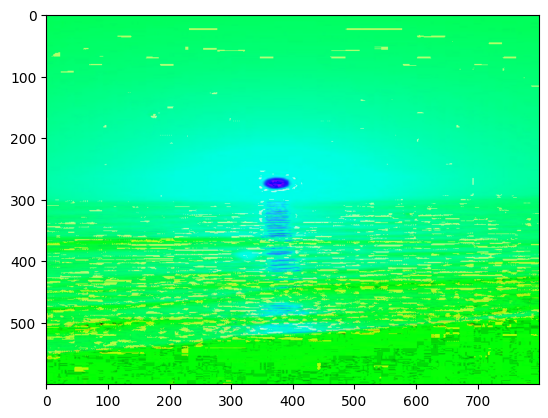

In [15]:
plt.imshow(images_hsv[poza_test])

**Ecuațiile de conversie**

Valorile R,G,B sunt împărțite la 255 pentru a modifica intervalul de la 0..255 la 0..1

*   R', G' și B' sunt ***valorile normalizate*** ale componentelor culorii RGB.
```
R' = R/255
G' = G/255
B' = B/255
```
*   Cmax este componenta maximă a culorii (maximul dintre R', G' și B') ***(intensitatea culorii predominante în imagine)***
```
Cmax = max(R', G', B')
```
*   Cmin este componenta minimă a culorii (minimul dintre R', G' și B').  ***(indică intensitatea culorii cel mai puțin predominante în imagine)***
```
Cmin = min(R', G', B')
```
*   Delta (***diferența maximă a culorii***)
```
delta = Cmax - Cmin
```

Valorile HSV

*   Hue: dacă delta este 0, atunci nuanța (H) este 0, deoarece nu există o nuanță distinctă în cazul în care toate componentele culorii sunt egale (culoare de gri).

```
- 60 * (G' - B') / delta, if Cmax = R'
- 60 * (B' - R') / delta + 120, if Cmax = G'
- 60 * (R' - G') / delta + 240, if Cmax = B'
```
*   Saturation: dacă Cmax este 0 (adică culoarea este negră), atunci saturația (S) este 0, deoarece nu există saturație în cazul unei culori negre.

```
- 0, if Cmax = 0
- delta/cmax, if Cmax != 0
```
*   Value:  indică nivelul de lumină al culorii.

```
- Cmax
```


Dimensiunile imaginii sunt afișate sub forma unui tuplu care conține înălțimea, lățimea și numărul de canale de culoare ale imaginii.

(HSV, aceasta este 3 pentru nuanță, saturație și valoare).

In [13]:
print("Image dimension : {}".format(images_hsv[poza_test].shape))

Image dimension : (600, 800, 3)


# Caracteristici de culoare:
 Imaginile din baza de date sunt procesate în prealabil pentru a extrage caracteristicile de culoare, cum ar fi histograma de culoare, momentele de culoare sau alte descriptori care reprezintă culoarea imaginii într-un format numeric.

**1) Histograma de culoare**

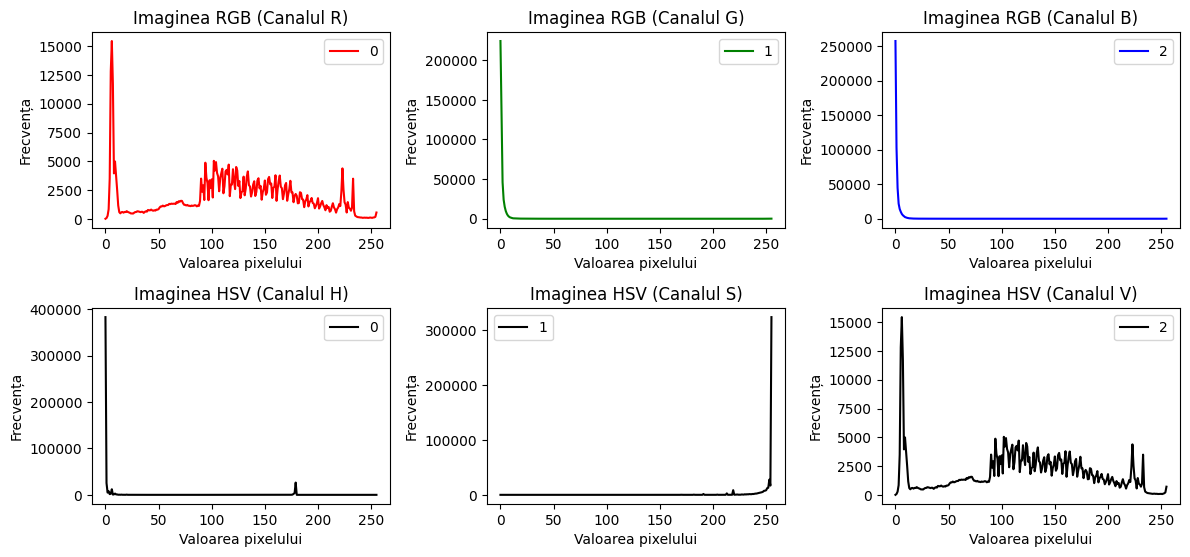

In [45]:
# Exemplu pentru o imagine RGB
image_rgb = images_rgb[poza_test]

# Exemplu pentru o imagine HSV
image_hsv = images_hsv[poza_test]

# Funcție pentru a afișa histograma pentru un canal de culoare într-un subplot
def plot_channel_histogram(image, title, channel_name, subplot_position, color):
    # Calculați histograma pentru canalul specificat
    hist = cv2.calcHist([image], [channel_name], None, [256], [0, 256])

    plt.subplot(subplot_position)
    plt.title(title)
    plt.xlabel("Valoarea pixelului")
    plt.ylabel("Frecvența")

    plt.plot(hist, color=color, label=channel_name)
    plt.legend()

plt.figure(figsize=(12, 8))

# Afișează histograma pentru fiecare canal de culoare separat pentru prima imagine RGB
plot_channel_histogram(image_rgb, "Imaginea RGB (Canalul R)", 0, 331, 'red')
plot_channel_histogram(image_rgb, "Imaginea RGB (Canalul G)", 1, 332, 'green')
plot_channel_histogram(image_rgb, "Imaginea RGB (Canalul B)", 2, 333, 'blue')

# Afișează histograma pentru fiecare canal de culoare separat pentru imaginea HSV
plot_channel_histogram(image_hsv, "Imaginea HSV (Canalul H)", 0, 334, 'black')
plot_channel_histogram(image_hsv, "Imaginea HSV (Canalul S)", 1, 335, 'black')
plot_channel_histogram(image_hsv, "Imaginea HSV (Canalul V)", 2, 336, 'black')


# Afișează toate subgraficele
plt.tight_layout()
plt.show()

**2) Media canalelor de culoare**

Funcția *get_mean* pe care ați definit-o primește o imagine (reprezentată sub formă de matrice de pixeli) și returnează valorile medii ale componentelor roșu (red), verde (green) și albastru (blue) ale imaginii. Acest lucru se face prin calcularea mediei valorilor de pixel pentru fiecare canal de culoare (R, G, B) al imaginii.

*   Extrage canalul roșu (R) al imaginii, care este primul canal (indice 0), și se calculează media valorilor pixelilor din acest canal. Aceasta reprezintă valoarea medie a culorii roșii din imagine.
```
mean_red = img[:,:,0].mean()
```

*   Extrage canalul albastru (B) al imaginii (indice 1 ) și se calculează media valorilor pixelilor din acest canal, reprezentând valoarea medie a culorii albastre din imagine.
```
mean_blue = img[:,:,1].mean()
```

*   Extrage canalul verde (G) al imaginii (indice 2 ) și se calculează media valorilor pixelilor din acest canal, reprezentând valoarea medie a culorii verzi din imagine.
```
mean_green = img[:,:,2].mean()
```

Funcția returnează un tuplu cu cele trei valori medii: (mean_red, mean_blue, mean_green).

In [16]:
def get_mean(img):
    mean_red = img[:,:,0].mean()
    mean_blue = img[:,:,1].mean()
    mean_green = img[:,:,2].mean()
    return(round(mean_red, 3), round(mean_blue, 3), round(mean_green, 3))

**3) Momentul canalelor de culoare**

Funcția get_moment primește o imagine sub formă de matrice de pixeli și calculează momentele de imagine pentru fiecare canal de culoare (roșu, verde și albastru) ale imaginii. În particular, calculează momentul de ordin 0 (momentul de masă sau momentul static).

*   Calculează momentul de imagine pentru canalul roșu (R) al imaginii, utilizând funcția cv2.moments din biblioteca OpenCV. 'm00' reprezintă momentul de masă sau momentul de ordin 0, care reflectă suprafața totală a zonei cu intensitatea de culoare (roșie) din imagine.
```
moment_red = cv2.moments(img[:,:,0])['m00']
```
*   Calculează momentul de imagine pentru canalul albastru (B) al imaginii, reflectând suprafața totală a zonei cu intensitatea de culoare albastră.
```
moment_blue = cv2.moments(img[:,:,1])['m00']
```

*   Calculează momentul de imagine pentru canalul verde (G) al imaginii, reflectând suprafața totală a zonei cu intensitatea de culoare verde.
```
moment_green = cv2.moments(img[:,:,2])['m00']
```

Funcția returnează un tuplu cu valorile momentelor de imagine calculate pentru cele trei canale de culoare: (moment_red, moment_blue, moment_green).

In [46]:
def get_moment(img):
    moment_red = cv2.moments(img[:,:,0])['m00']
    moment_blue = cv2.moments(img[:,:,1])['m00']
    moment_green = cv2.moments(img[:,:,2])['m00']
    return (round(moment_red, 3), round(moment_blue, 3), round(moment_green, ))

In [47]:
imageDB = pd.DataFrame()

In [48]:
imageDB['image_matrix'] = images_rgb
imageDB['mean'] = imageDB['image_matrix'].apply(get_mean)
imageDB['moment'] = imageDB['image_matrix'].apply(get_moment)

# Algoritm de comparare:
Un algoritm de comparație este utilizat pentru a evalua similitudinea între caracteristicile de culoare ale imaginilor interogate și cele din baza de date. Acest algoritm poate utiliza măsuri de distanță, cum ar fi distanța euclidiană sau coeficientul de corelație, pentru a determina cât de asemănătoare sunt imaginile.

Funcția euclidean_distance pe care ați definit-o calculează distanța euclidiană între două puncte sau vectori tridimensionali, reprezentați ca tupluri (x[0], x[1], x[2]) și (y[0], y[1], y[2]). Această distanță euclidiană este măsura "distanței" sau "diferenței" dintre aceste două puncte în spațiul tridimensional.
Pentru a măsura cât de diferite sau similare sunt două imagini în funcție de caracteristicile lor de culoare, cum ar fi media de culoare.

In [49]:
def euclidean_distance(x=(0,0,0), y=(0,0,0)):
    return np.sqrt(np.square(x[0] - y[0])
                   + np.square(x[1] - y[1])
                   + np.square(x[2] - y[2]))

Acest cod definește o funcție numită query care efectuează o căutare într-o bază de date de imagini bazată pe diferite caracteristici ( medie de culoare sau moment de culoare) pentru o imagine de interogare specificată. Funcția afișează apoi un număr specificat de imagini similare din baza de date în funcție de caracteristica specificată.

Căutarea după mean:

Funcția get_mean este utilizată pentru a obține valoarea medie a culorii imaginii de interogare.
Similaritatea dintre valoarea medie a culorii imaginii de interogare și valorile medii ale culorilor imaginilor din baza de date este calculată folosind euclidean_distance.
Imaginile din baza de date sunt sortate în funcție de similaritatea lor cu valoarea medie a culorii imaginii de interogare.
Se afișează primele rank imagini cu cele mai mari similarități ale mediei de culoare.

Căutarea după moment:

Funcția get_moment este utilizată pentru a obține momentul imaginii de interogare.
Similaritatea dintre momentul imaginii de interogare și momentele imaginilor din baza de date este calculată folosind euclidean_distance.
Imaginile din baza de date sunt sortate în funcție de similaritatea lor cu momentul imaginii de interogare.
Se afișează primele rank imagini cu cele mai mici similarități ale momentelor de culoare, deoarece momentele mici indică similaritatea.

In [50]:
def query(query_img, DB, by='mean', rank=10):
    if  by == 'mean':
         # Calcularea valorii medii a culorii pentru imaginea de interogare
        mean = get_mean(query_img)

         # Calcularea similarității și sortarea imaginilor în funcție de valoarea medie a culorii
        similarity_mean = DB['mean'].map(lambda x : euclidean_distance(mean, x))
        similarity_mean = similarity_mean.to_dict()
        similar_images_mean = sorted(similarity_mean, key=similarity_mean.get)

         # Afișarea imaginilor și valorilor medii

        f, axarr = plt.subplots(1, rank, sharex=True, figsize=(20, 5))
        f.suptitle('Similar Images by Mean Color')
        for i in range(rank):
            similar_image = similar_images_mean[i]
            axarr[i].imshow(imageDB.iloc[similar_image][0])
            axarr[i].set_title(f'Mean: {imageDB.iloc[similar_image]["mean"]}')
    elif by == 'moment':
         # Calcularea momentului de culoare pentru imaginea de interogare
        moment = get_moment(query_img)

        # Calcularea similarității și sortarea imaginilor în funcție de momentul de culoare
        similarity_moment = DB['moment'].map(lambda x: euclidean_distance(moment, x))
        similarity_moment = similarity_moment.to_dict()
        similar_images_moment = sorted(similarity_moment, key=similarity_moment.get)[:rank]

        # Afișarea imaginilor și valorilor momentului de culoare sub forma unor coloane separate

        f, axarr = plt.subplots(1,rank, sharex=True, figsize=(20,5))
        f.suptitle('Similar Images by Color Moment')
        for i in range(rank):
            similar_image = similar_images_moment[i]
            axarr[i].imshow(imageDB.iloc[similar_image][0])
            axarr[i].set_title(f'Moment: {imageDB.iloc[similar_image]["moment"]}')

# Indexare:
Aceste caracteristici de culoare sunt indexate și stocate într-o bază de date sau într-o structură de date optimizată pentru căutarea rapidă a imaginilor similare.

**Image Database**

In [51]:
imageDB

,image_matrix,mean,moment
0,"[[[10, 23, 14], [26, 39, 30], [34, 47, 38], [4...","(83.01, 52.833, 34.643)","(39844712.0, 25359633.0, 16628625)"
1,"[[[9, 62, 104], [8, 61, 103], [8, 61, 103], [8...","(106.905, 82.317, 71.352)","(51314398.0, 39512184.0, 34248948)"
2,"[[[127, 133, 135], [125, 132, 134], [123, 130,...","(108.362, 102.911, 100.681)","(52013856.0, 49397267.0, 48326962)"
3,"[[[180, 195, 171], [189, 200, 176], [191, 194,...","(137.491, 146.427, 155.699)","(65995594.0, 70284730.0, 74735452)"
4,"[[[144, 9, 5], [144, 9, 5], [144, 9, 5], [144,...","(81.17, 41.759, 26.416)","(38961717.0, 20044264.0, 12679660)"
5,"[[[131, 114, 94], [130, 114, 94], [130, 115, 9...","(179.823, 159.305, 116.022)","(86315166.0, 76466235.0, 55690437)"
6,"[[[0, 0, 48], [0, 0, 48], [0, 0, 48], [0, 0, 4...","(9.328, 14.181, 102.336)","(4477640.0, 6807059.0, 49121054)"
7,"[[[224, 215, 216], [228, 219, 220], [227, 218,...","(169.08, 128.373, 130.041)","(81158449.0, 61618971.0, 62419837)"
8,"[[[217, 206, 240], [216, 205, 239], [216, 205,...","(190.891, 161.588, 201.757)","(91627866.0, 77562329.0, 96843282)"
9,"[[[79, 146, 189], [79, 146, 189], [80, 147, 19...","(94.471, 162.998, 210.876)","(45345891.0, 78238910.0, 101220307)"


# Rezultate:
Sistemul returnează imaginile din baza de date care sunt cele mai similare cu imaginea de interogare.

**În funcție de media de culoare**

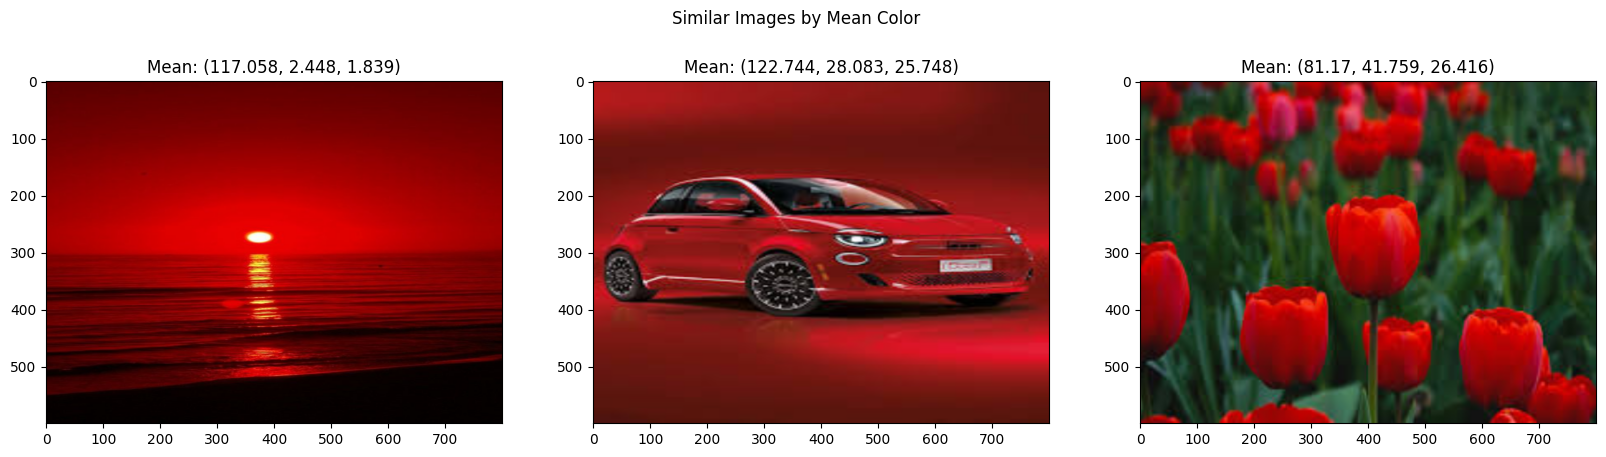

In [52]:
query(images_rgb[poza_test],imageDB, by='mean', rank=3)

**În funcție de momentul de culoare:**

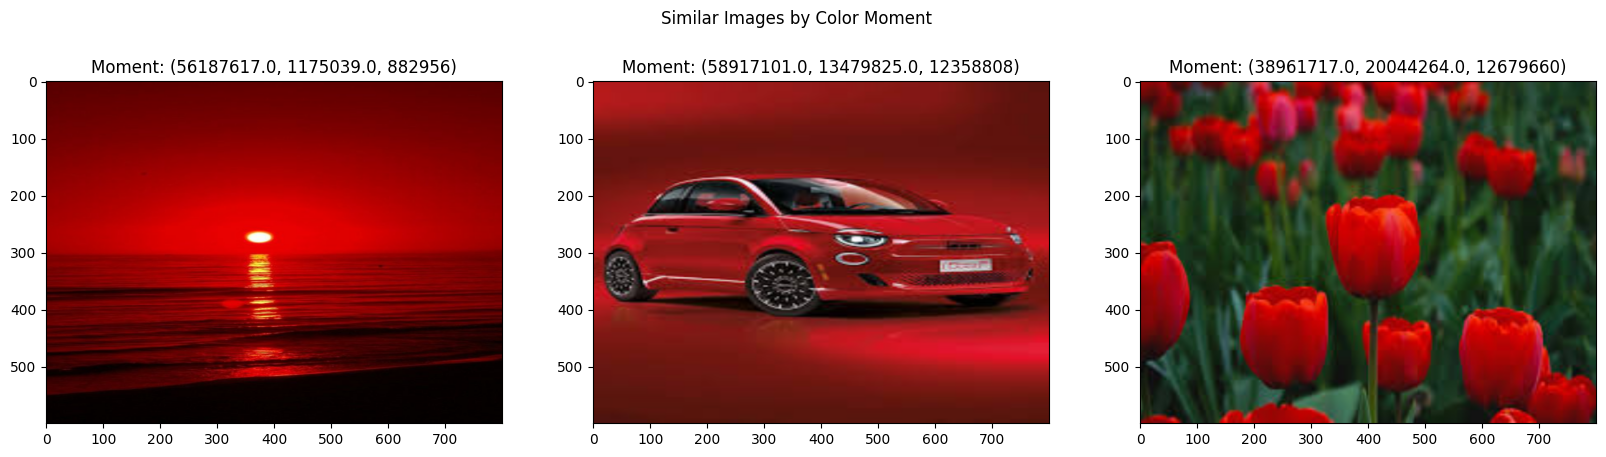

In [53]:
query(images_rgb[poza_test],imageDB, by='moment', rank=3)


**Prin urmare, vedem că rezultatele sunt similare vizual.**